In [1]:
import tensorflow as tf
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import skimage.transform as tform
import os

couldn't import doomish
Couldn't import doom


In [2]:
#################################################################
### Headless op                         #########################
os.putenv('SDL_VIDEODRIVER', 'fbcon')   #########################
os.environ["SDL_VIDEODRIVER"] = "dummy" #########################
#################################################################

In [2]:
p = PLE(FlappyBird(), reward_values={"positive": 1.0, "loss": -1.0, "tick": 0.0,}, fps=30, display_screen=False, force_fps=True)
#p = PLE(FlappyBird(), reward_values={"positive": 1.0, "loss": -1.0, "tick": 0.0,}, fps=30, display_screen=True, force_fps=False)

In [3]:
p.init()

In [4]:
%%time

p.reset_game()

games = 0
total_rewards = []

while games < 1:
    action = np.random.choice([0,119], p=[.9,.1])
    reward = p.act(action)
    
    total_rewards.append(reward)
    
    if p.game_over():
        p.reset_game()
        games += 1

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 46 ms


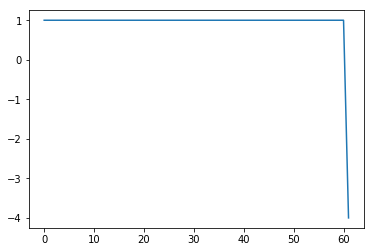

In [5]:
plt.plot(total_rewards)
plt.show()

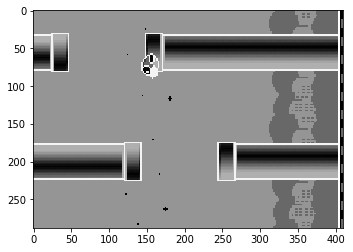

In [7]:
pic = p.getScreenRGB()
plt.imshow(pic[:,:410,1], cmap='Greys')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


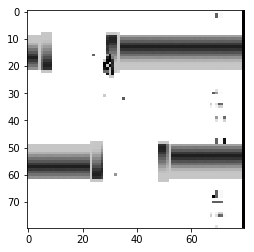

In [8]:
pic = p.getScreenRGB()
pic = pic[:,:410,0]
pic = tform.resize(pic, (80,80))
plt.imshow(pic, cmap='Greys')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


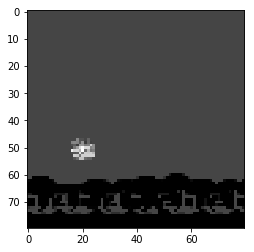

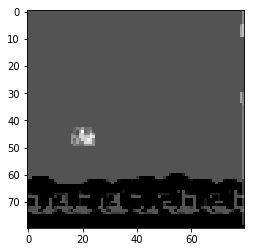

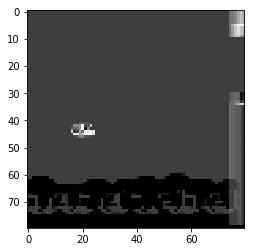

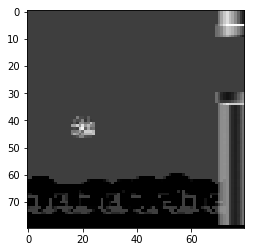

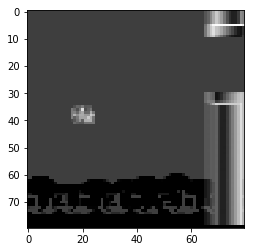

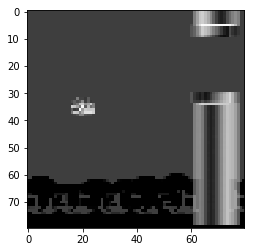

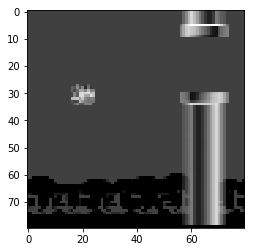

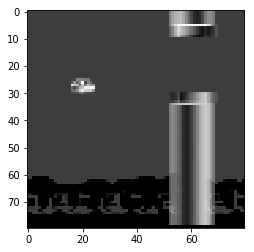

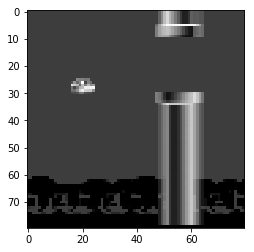

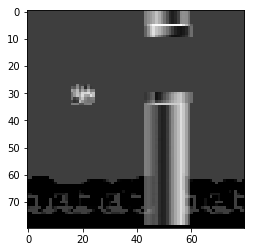

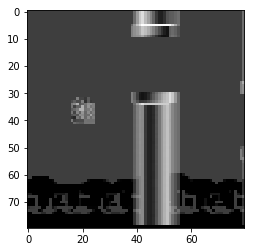

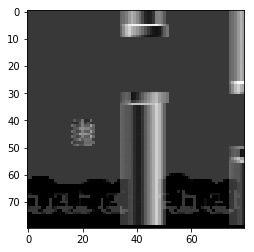

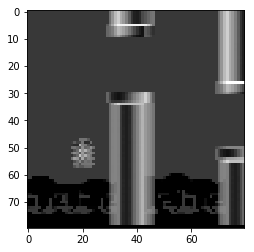

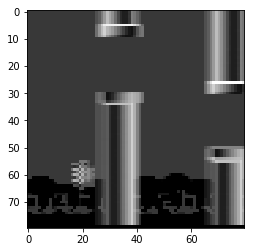

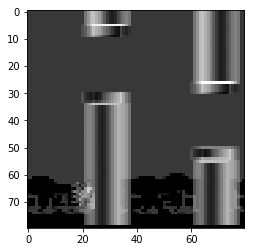

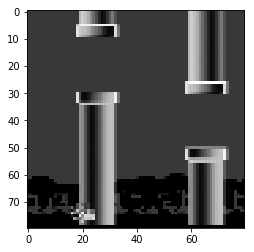

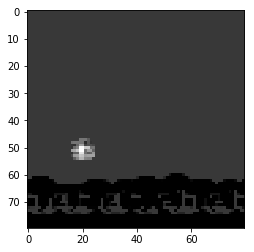

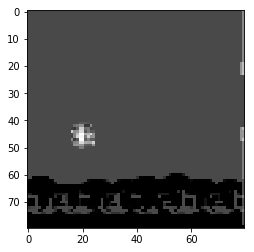

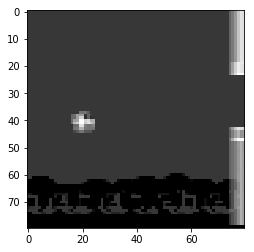

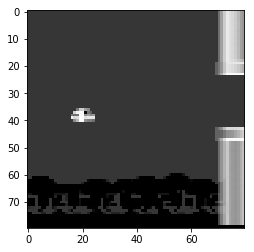

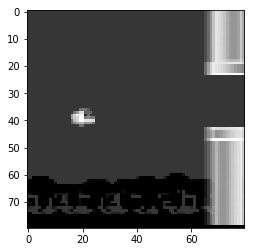

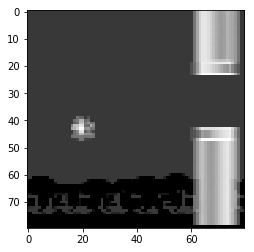

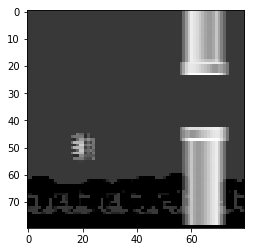

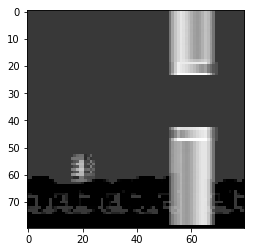

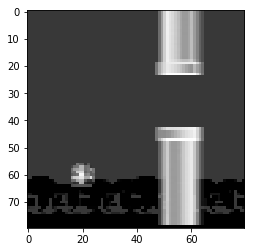

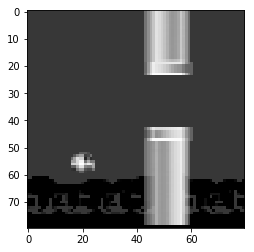

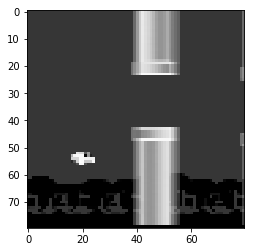

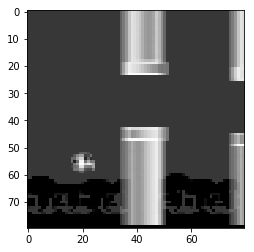

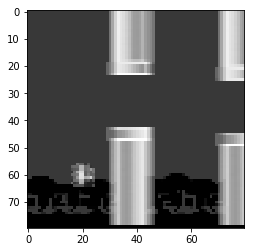

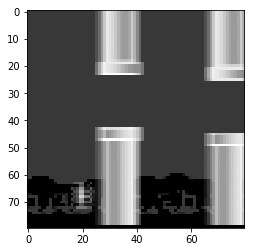

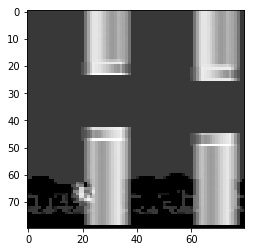

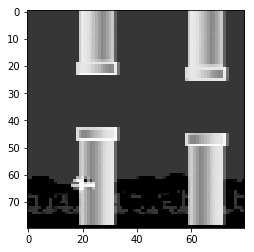

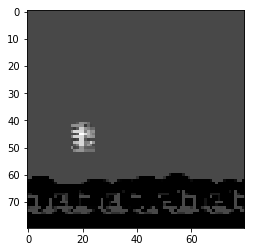

In [9]:
games = 0
stknm = 4

def prepro(img):
    img = np.sum(img, axis=3)
    img = img[:,:410,1]
    img = tform.resize(img, (80,80))
    return np.reshape(img, [1,80,80,1])

while games < 2:

    if p.game_over():
        p.reset_game()
        games += 1   

    frame_buffer = np.zeros((288, 512, 3, stknm))

    for jj in range(stknm):
        action = np.random.choice([0,119], p=[.9,.1])
        reward = p.act(action)
        frame_buffer[:,:,:,jj] = p.getScreenRGB()

    temp = prepro(frame_buffer)

    plt.imshow(np.transpose(temp[0,:,:,0]), cmap='Greys')
    plt.show()

# policy gradient learner

In [72]:
%%time

#init
gamma = 0.99
total_episodes = 10
max_ep = 999999
update_frequency = 5
stknm = 4

# forward discount reward function
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# stack frame buffer, crop + greyscale, stretch, and normalize
def prepro(img):
    img = np.sum(img, axis=3)
    img = img[:,:410,1]
    img = tform.resize(img, (80,80))
    img = img - np.amin(img)
    img = img / np.amax(img)
    img = img - 0.5
    img = img / 0.5
    return np.reshape(img, [1,80,80,1])
    
class agent():
    def __init__(self, lr, s_size, a_size):
        # init placeholders
        self.state_in= tf.placeholder(shape=[None, s_size, s_size, 1],dtype=tf.float32, name='input')
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32, name='reward_holder')
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32, name='action_holder')
        
        # define weight matrices
        w1 = tf.Variable(tf.random_normal([8,8,1,32], stddev=1), trainable=True, name='w1')
        w2 = tf.Variable(tf.random_normal([4,4,32,64], stddev=1), trainable=True, name='w2')
        w3 = tf.Variable(tf.random_normal([3,3,64,64], stddev=1), trainable=True, name='w3')
        w4 = tf.Variable(tf.random_normal([6400, 512], stddev=1), trainable=True, name='w4')
        w5 = tf.Variable(tf.random_normal([512, a_size], stddev=1), trainable=True, name='w5')
        
        # weight matrix histogram summaries
        tf.summary.histogram('w1_summ', w1)
        tf.summary.histogram('w2_summ', w2)
        tf.summary.histogram('w3_summ', w3)
        tf.summary.histogram('w4_summ', w4)
        
        # build model
        with tf.name_scope('conv1'):
            conv1 = tf.nn.relu(tf.nn.conv2d(self.state_in, filter=w1, strides=[1,1,1,1], padding='SAME'))
            pool1 = tf.nn.max_pool(conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
        with tf.name_scope('conv2'):
            conv2 = tf.nn.relu(tf.nn.conv2d(pool1, filter=w2, strides=[1,1,1,1], padding='SAME'))
            pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        with tf.name_scope('conv3'):
            conv3 = tf.nn.relu(tf.nn.conv2d(pool2, filter=w3, strides=[1,1,1,1], padding='SAME'))
            pool3 = tf.nn.max_pool(conv3, ksize=[1,1,1,1], strides=[1,1,1,1], padding='SAME')
        with tf.name_scope('flatten'):
            flat = tf.reshape(conv3, [-1, 6400])
            dense1 = tf.nn.relu(tf.matmul(flat, w4))
        with tf.name_scope('output'):
            self.output = tf.nn.softmax(tf.matmul(dense1, w5))
        
        # calculate loss
        with tf.name_scope('loss_op'):
            self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
            self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

            #self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
            self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs*119)*self.reward_holder)
            #tf.summary.scalar('loss', self.loss)
        
        #self.re_hol = self.reward_holder
        
        # init
        tvars = tf.trainable_variables()
        
        self.varry = tvars
        
        # gradients
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32, name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss, tvars)
        
        # build optimizer and backprop
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
        
# init
tf.reset_default_graph()
myAgent = agent(lr=0.01, s_size=80, a_size=2)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # logs
    writer = tf.summary.FileWriter('../logs/PG', sess.graph)
    merged = tf.summary.merge_all()
    
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []

    # build a gradient buffer for batched updates
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    # run an episode
    while i < total_episodes:
        print('game number: ', i)
        
        # reset and build initial frame buffer
        p.reset_game()
        frame_buffer = np.zeros((288, 512, 3, stknm))
        for jj in range(stknm):
            r = p.act(0)
            frame_buffer[:,:,:,jj] = p.getScreenRGB()
        s = prepro(frame_buffer)
        
        running_reward = 0
        ep_history = []
        
        # limit frames
        for j in range(max_ep):
            # get an action from the agent
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:s})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)
            a = a * 119
                       
            # act on environment and observe the reward and new state
            r = p.act(a)
            frame_buffer = np.roll(frame_buffer, -1, axis=3)
            frame_buffer[:,:,:,-1] = p.getScreenRGB()
            s1 = prepro(frame_buffer)
            ep_history.append([s,a/119,r,s1])
            s = s1
            running_reward += r
            
            if p.game_over() == True:
                # stack out an episode history and discount rewards
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                
                # calculate gradients
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                
                #################
                #print(np.amax(grads[0]), np.amax(grads[1]), np.amax(grads[2]), np.amax(grads[3]), np.amax(grads[4]))
                #print(sess.run(myAgent.loss, feed_dict=feed_dict))
                #if i == 0: print(sess.run(myAgent.varry, feed_dict=feed_dict))
                #print(sess.run(myAgent.output, feed_dict=feed_dict).shape)
                #print(sess.run(myAgent.re_hol, feed_dict=feed_dict).shape)
                #print(sess.run(myAgent.responsible_outputs, feed_dict=feed_dict))
                #print(sess.run(tf.log(myAgent.responsible_outputs*119), feed_dict=feed_dict))
                ###################
                
                # back propagate gradients
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                # log
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        # log
        summary = sess.run(merged, feed_dict=feed_dict)
        writer.add_summary(summary, i)
        
        i += 1

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


game number:  0
game number:  1
game number:  2
game number:  3
game number:  4
game number:  5
game number:  6
game number:  7
game number:  8
game number:  9
CPU times: user 15.5 s, sys: 11.1 s, total: 26.7 s
Wall time: 8.55 s


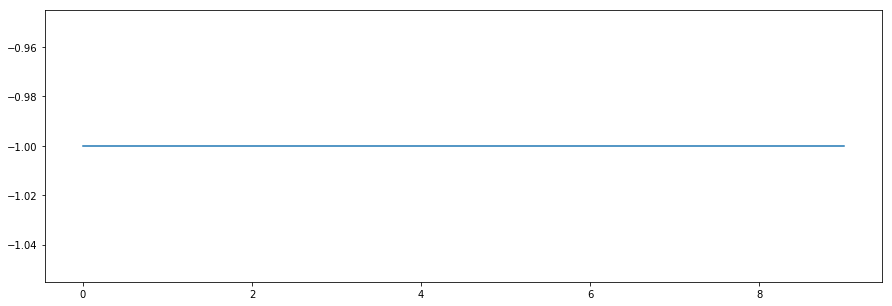

In [73]:
plt.figure(figsize=(15,5))
plt.plot(total_reward)
plt.show()

1,000 episodes took 3.25 minutes, so 10,000 should take 32.5 minutes, 100,000 should take 325 minutes (5.4 hours), 1,000,000 should take 3250 minutes (2.26 days).

In [69]:
grads

[array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         ..., 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
 
 
        [[[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         ..., 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
 
 
        [[[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         ..., 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
 
 
        ..., 
        [[[ 0.,  0.,  0., ...,  

In [ ]:
with tf.Session() as sess:
    